In [188]:
import os
import numpy as np
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import random
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D, Lambda
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model
import keras.backend as K
from keras.models import load_model
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#Directory
train_dir = "data/train"
test_dir = "data/test"

In [3]:
#Load image to number array
def load_img_array(path):
    X = []
    y = []
    class_names = []
    label_count = 0
    alphabets = os.listdir(path)
    for alphabet in alphabets:
        alphabet_path = os.path.join(path, alphabet)
        characters = os.listdir(alphabet_path)
        for character in characters:
            character_path = os.path.join(path, alphabet, character)
            images = os.listdir(character_path)
            for image in images:
                image_path = os.path.join(path, alphabet, character, image)
                img = load_img(image_path, color_mode="grayscale", target_size=(28,28))
                img = img_to_array(img)/255.
                X.append(img)
                y.append(label_count)
            class_names.append(alphabet+"|"+character)
            label_count += 1
    X = np.stack(X).astype('float32')
    y = np.stack(y).astype('float32')
    
    return X, y, class_names

train_imags, train_labels, train_classes = load_img_array(train_dir)
test_imags, test_labels, test_classes = load_img_array(test_dir)

In [4]:
print(f"train shape: {train_imags.shape}, {train_labels.shape}")
print(f"test shape: {test_imags.shape}, {test_labels.shape}")

train shape: (22722, 28, 28, 1), (22722,)
test shape: (9738, 28, 28, 1), (9738,)


In [5]:
# Create Pair
def make_pairs(images, labels):
    num_classes = int(max(labels))+1
    label_indices = [np.where(labels==i)[0] for i in range(num_classes)]
    pairs = []
    pair_labels = []

    for idx1 in range(len(images)):
        # add a matching example
        x1 = images[idx1]
        label1 = labels[idx1]
        idx2_lists = label_indices[int(label1)]
        for idx2 in idx2_lists:
            x2 = images[idx2]
            pairs += [[x1, x2]]
            pair_labels += [1]

        # add a non-matching example
        label2_list = np.random.choice(num_classes, size=len(idx2_lists), replace=False)
        while [l for l in label2_list if l == label1]:
            label2_list = np.random.choice(num_classes, size=len(idx2_lists), replace=False)
        
        for label2 in label2_list:
            idx2 = np.random.choice(label_indices[label2], size=1)[0]
            x2 = images[idx2]
            pairs += [[x1, x2]]
            pair_labels += [0]

    X = np.array(pairs).astype("float32")
    y = np.array(pair_labels).astype("float32")
    return X, y

X_train, y_train = make_pairs(train_imags, train_labels)
X_test, y_test = make_pairs(test_imags, test_labels)

In [6]:
print(f"train pair shape: {X_train.shape}, {y_train.shape}")
print(f"test pair shape: {X_test.shape}, {y_test.shape}")

train pair shape: (636216, 2, 28, 28, 1), (636216,)
test pair shape: (116856, 2, 28, 28, 1), (116856,)


SAME


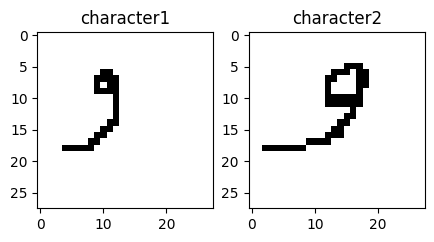

In [7]:
#Random plot image pair
def plot_pair(images, labels):
    idx_rand = random.randint(0, len(images)-1)
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(images[idx_rand][0], cmap="gray")
    plt.title("character1")

    plt.subplot(1,2,2)
    plt.imshow(images[idx_rand][1], cmap="gray")
    plt.title("character2")

    print(["NOT SAME", "SAME"][int(labels[idx_rand])])

plot_pair(X_train, y_train)

In [18]:
#Create embedding network
def embedding_network():
    input = Input(shape=(28, 28, 1))
    x = Conv2D(4, 5, activation="relu")(input)
    x = MaxPool2D(2)(x)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)

    return Model(inputs=input, outputs=x)

embedding_layer = embedding_network()
embedding_layer.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 4)         104       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 4)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               73856     
                                                                 
Total params: 73,960
Trainable params: 73,960
Non-trainable params: 0
_______________________________________________________

In [17]:
#Create euclidean_distance
def euclidean_distance(vects):
  '''
  Calculate euclidean between two vectors
  http://mathonline.wikidot.com/the-distance-between-two-vectors
  '''
  x, y = vects
  sum_squares = K.sum(K.square(x-y), axis=1, keepdims=True)
  # K.epsilon() = 1e-07 -> prevent number goes to small
  return K.sqrt(K.maximum(sum_squares, K.epsilon()))

In [16]:
#Create Siamese network
input_left = Input(shape=(28, 28, 1), name='left_input')
input_right = Input(shape=(28, 28, 1), name='right_input')

encoded_left = embedding_layer(input_left)
encoded_right = embedding_layer(input_right)

lambda_layer = Lambda(function=euclidean_distance, name='output_layer')
output = lambda_layer([encoded_left, encoded_right])


model = Model(inputs=[input_left, input_right],outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128)          73960       ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 output_layer (Lambda)          (None, 1)            0           ['model[2][0]',            

In [11]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    '''
    Dunno why the author of the course remove the 1/2 away ┐(￣ヘ￣)┌
    Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin-y_pred, 0))
    return ((1 - y_true) * margin_square + y_true * square_pred)
  return contrastive_loss

In [20]:
#Compile model
model.compile(loss=contrastive_loss_with_margin(margin=1), 
              optimizer=Adam())

#Fit model
history = model.fit(x=[X_train[:, 0], X_train[:, 1]],
                    y=y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/10
4971/4971 [==============================] - 195s 39ms/step - loss: 0.1237 - val_loss: 0.1107
Epoch 2/10
4971/4971 [==============================] - 176s 35ms/step - loss: 0.1049 - val_loss: 0.1073
Epoch 3/10
4971/4971 [==============================] - 156s 31ms/step - loss: 0.1005 - val_loss: 0.1032
Epoch 4/10
4971/4971 [==============================] - 166s 33ms/step - loss: 0.0991 - val_loss: 0.1028
Epoch 5/10
4971/4971 [==============================] - 162s 33ms/step - loss: 0.0983 - val_loss: 0.1036
Epoch 6/10
4971/4971 [==============================] - 153s 31ms/step - loss: 0.0983 - val_loss: 0.1025
Epoch 7/10
4971/4971 [==============================] - 160s 32ms/step - loss: 0.0980 - val_loss: 0.1022
Epoch 8/10
4971/4971 [==============================] - 162s 33ms/step - loss: 0.0979 - val_loss: 0.1028
Epoch 9/10
4971/4971 [==============================] - 173s 35ms/step - loss: 0.0978 - val_loss: 0.1033
Epoch 10/10
4971/4971 [==============================] 

In [21]:
def compute_accuracy(y_true, y_pred):
  '''
  Compute classification accuracy with a fixed threshold on distances
  '''
  pred = y_pred.ravel() < 0.5
  return np.mean(pred==y_true)

In [22]:
y_pred_train = model.predict([X_train[:,0], X_train[:,1]])
train_accuracy = compute_accuracy(y_train, y_pred_train)

y_pred_test = model.predict([X_test[:,0], X_test[:,1]])
test_accuracy = compute_accuracy(y_test, y_pred_test)

print("Train Accuracy = {} Test Accuracy = {}".format(train_accuracy, test_accuracy))

3652/3652 [==============================] - 19s 5ms/step
Train Accuracy = 0.9074763916657236 Test Accuracy = 0.8879304443075238


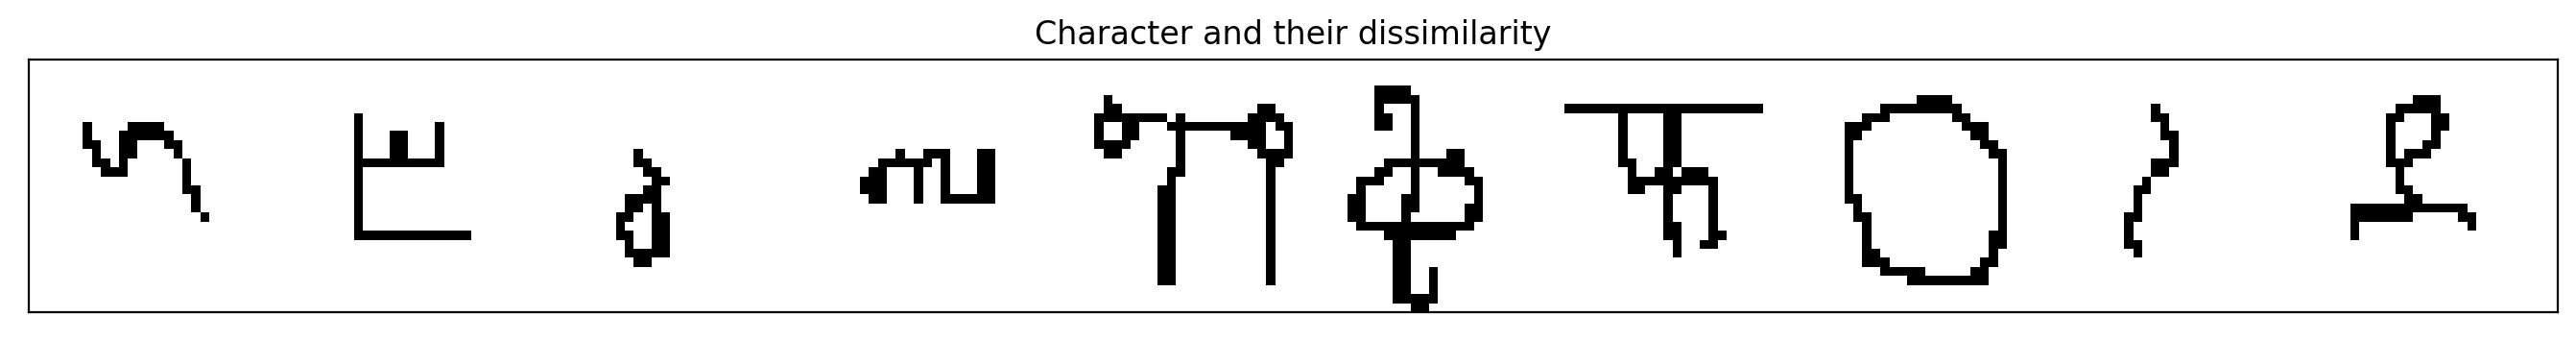

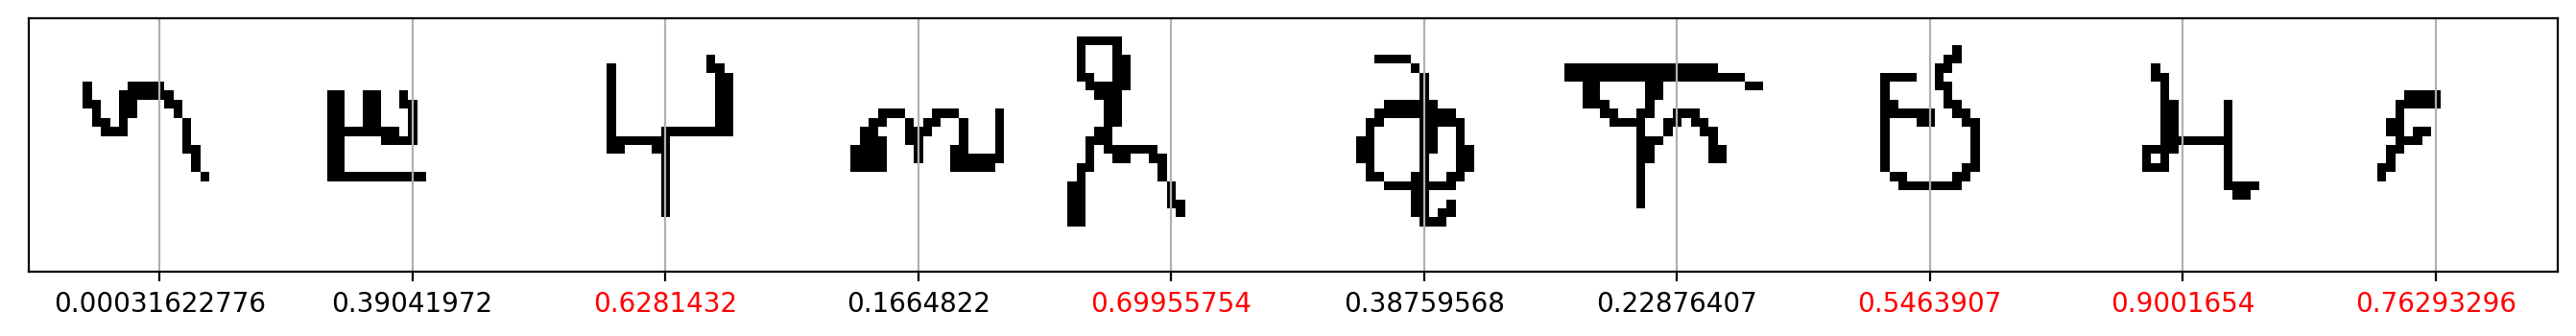

In [340]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left, cmap="gray")
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right, cmap="gray")

y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(X_train[:,0][indexes], X_train[:,1][indexes], y_pred_train[indexes], y_train[indexes], 'Character and their dissimilarity', 10)

In [24]:
#Save weight
model.save_weights('model_weights.h5')

In [103]:
# Few shot learning
def few_shot_task(support_datas, support_labels, test_images, test_labels, way=2, shot=1):
    test_labels = int(test_labels)
    num_classes = int(max(support_labels))+1
    label_indices = [np.where(support_labels==i)[0] for i in range(num_classes)]
    support_list = []
    pairs = []

    support_idxs = [test_labels]
    support_rnd_idxs = list(np.random.choice(num_classes, size=way-1, replace=False))
    while [i for i in support_rnd_idxs if i==test_labels]:
        support_rnd_idxs = list(np.random.choice(num_classes, size=way-1, replace=False))
    support_idxs += support_rnd_idxs

    for support_idx in support_idxs:
        idx_rand = list(np.random.choice(label_indices[support_idx], size=shot, replace=False))
        support_list.append(idx_rand)

    for idxs in support_list:
        sub_pairs = []
        for idx in idxs:
            sub_pairs += [[test_images, support_datas[idx]]]
        
        pairs.append(sub_pairs)

    pair_labels = np.zeros((way))
    pair_labels[0] = 1
    pairs = np.array(pairs).astype("float32")

    return pairs, pair_labels

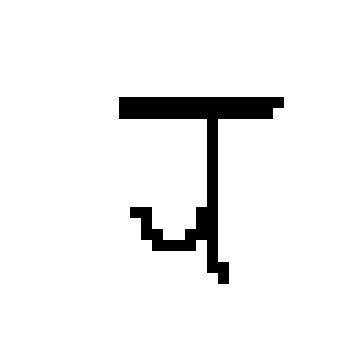

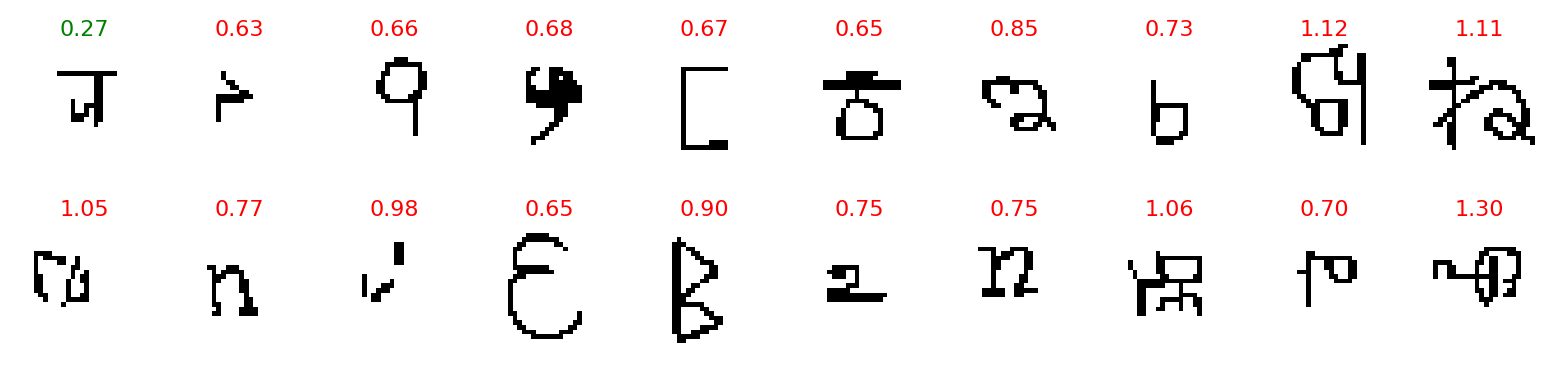

In [260]:
#Visualize
WAY = 20
SHOT = 5
idx = random.randint(0, len(test_labels))
test_image, label_image = test_imags[idx], test_labels[idx]

inputs, targets = few_shot_task(support_datas=train_imags, support_labels=train_labels, test_images=test_image, test_labels=label_image, way=WAY, shot=SHOT)

results = []
for input in inputs:
    predict = model.predict([input[:,0], input[:,1]], verbose=0)
    predict_avg = np.mean(predict)
    results.append(predict_avg)
    
predict_idx = np.argmin(results)

plt.figure(figsize=(2,2))
plt.imshow(test_image, cmap="gray")
plt.axis(False)
plt.show()

ncols = 10
nrows = (WAY // ncols) + ((WAY % ncols) > 0)
fig = plt.figure(figsize=(10, nrows))
plt.subplots_adjust(wspace= 0, hspace= 0.4)
for i in range(WAY):
    sub = fig.add_subplot(nrows, ncols, i+1)
    rnd_idx = np.random.choice(SHOT)
    sub.imshow(inputs[i,rnd_idx,1], cmap="gray")
    if i == predict_idx:
        title_color = "green"
    else:
        title_color = "red"
    sub.set_title(f"{results[i]:.2f}", fontsize=8, color=title_color, pad=0)
    plt.axis(False)

In [308]:
#Calculate Accuracy
def few_shot_accuracy(model, images, labels, n_sample, way, shot):
    n_correct = 0
    rnd_idx = np.random.choice(len(test_imags), size=n_sample, replace=False)
    test_images = test_imags[rnd_idx]
    label_images = test_labels[rnd_idx]    

    for test_image, label_image in zip(test_images, label_images):
        inputs, targets = few_shot_task(support_datas=train_imags, 
                                        support_labels=train_labels, 
                                        test_images=test_image, 
                                        test_labels=label_image, 
                                        way=way, 
                                        shot=shot)
        results = []
        for input in inputs:
            predict = model.predict([input[:,0], input[:,1]], verbose=0)
            predict_avg = np.mean(predict)
            results.append(predict_avg)
        
        if np.argmin(results) == 0:
            n_correct += 1

    accuracy = (100.0 * n_correct / n_sample)
    
    return accuracy

accuracy = few_shot_accuracy(model, images=test_imags, labels=test_labels, n_sample=100, way=20, shot=5)
print(accuracy)

73.0


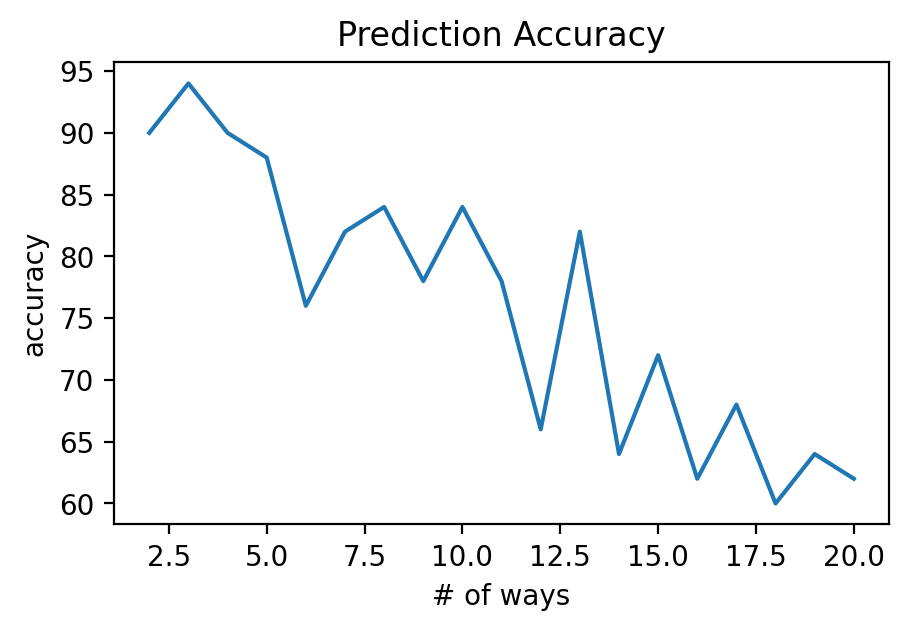

In [328]:
# Adjust # of ways
n_sample = 50
shot = 1
way = 20
accuracy_list = []
way_list = []
for w in range(2,way+1):
    accuracy = few_shot_accuracy(model, images=test_imags, labels=test_labels, n_sample=n_sample, way=w, shot=shot)
    accuracy_list.append(accuracy)
    way_list.append(w)

plt.figure(figsize=(5,3))
plt.plot(way_list, accuracy_list)
plt.title("Prediction Accuracy")
plt.xlabel("# of ways")
plt.ylabel("accuracy")
plt.show()

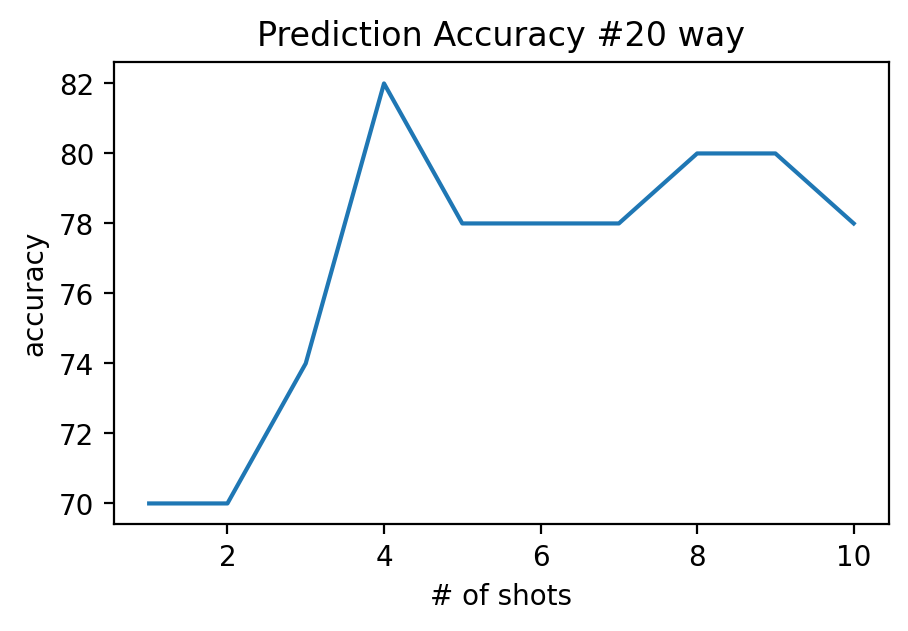

In [334]:
# Adjust # of shot
n_sample = 50
shot = 10
way = 20
accuracy_list = []
shot_list = []
for s in range(1,shot+1):
    accuracy = few_shot_accuracy(model, images=test_imags, labels=test_labels, n_sample=n_sample, way=way, shot=s)
    accuracy_list.append(accuracy)
    shot_list.append(s)

plt.figure(figsize=(5,3))
plt.plot(shot_list, accuracy_list)
plt.title("Prediction Accuracy #20 way")
plt.xlabel("# of shots")
plt.ylabel("accuracy")
plt.show()